In [60]:
# ============================================================
# 04_model_selection_report_and_export.ipynb
# Medical Cost Prediction — Nested CV, Final Fit, Learning Curve, Export
# Models: Linear, Ridge, Lasso, ElasticNet (+ log metrics, no new models!)
# ============================================================

# 1) Imports & Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns, os, joblib

sns.set(style="whitegrid", rc={"figure.figsize": (7,5)})
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [61]:
# 2) Load
df = pd.read_csv("../data/insurance.csv")
print(df.shape, "rows, cols | missing:", df.isna().sum().sum())

(1338, 7) rows, cols | missing: 0


In [62]:
# 3) Feature Engineering 
df_fe = df.copy()
df_fe["smoker_int"] = (df_fe["smoker"] == "yes").astype(int)
df_fe["smoker_age"] = df_fe["smoker_int"] * df_fe["age"]
df_fe["smoker_bmi"] = df_fe["smoker_int"] * df_fe["bmi"]
df_fe["age_bmi"]    = df_fe["age"] * df_fe["bmi"]

target = "charges"
base_num = ["age","bmi","children"]
eng_num  = ["smoker_age","smoker_bmi","age_bmi"]
num_cols = base_num + eng_num
cat_cols = ["sex","smoker","region"]

X = df_fe.drop(columns=[target, "smoker_int"])
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
# 3) Feature Engineering 
df_fe = df.copy()
df_fe["smoker_int"] = (df_fe["smoker"] == "yes").astype(int)
df_fe["smoker_age"] = df_fe["smoker_int"] * df_fe["age"]
df_fe["smoker_bmi"] = df_fe["smoker_int"] * df_fe["bmi"]
df_fe["age_bmi"]    = df_fe["age"] * df_fe["bmi"]

target = "charges"
base_num = ["age","bmi","children"]
eng_num  = ["smoker_age","smoker_bmi","age_bmi"]
num_cols = base_num + eng_num
cat_cols = ["sex","smoker","region"]

X = df_fe.drop(columns=[target, "smoker_int"])
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [63]:
# 4) Preprocessor
num_transformer = Pipeline([("scaler", StandardScaler())])
cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

In [64]:
# 5) Helpers (metrics, reporting)
def mape(y_true, y_pred):
    return 100*np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9)))

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def report_all(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mp   = mape(y_true, y_pred)
    rl   = rmsle(y_true, y_pred)
    print(f"[{name}] RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f} | MAPE: {mp:.2f}% | RMSLE: {rl:.4f}")
    return rmse, mae, r2, mp, rl


In [65]:
# 6) Model grids 
models = {
    "Linear": (LinearRegression(), {}),  
    "Ridge": (Ridge(random_state=RANDOM_STATE), {"model__alpha": np.logspace(-3, 3, 25)}),
    "Lasso": (Lasso(max_iter=50000, random_state=RANDOM_STATE), {"model__alpha": np.logspace(-4, 2, 25)}),
    "ElasticNet": (ElasticNet(max_iter=50000, random_state=RANDOM_STATE),
                   {"model__alpha": np.logspace(-4, 2, 30),
                    "model__l1_ratio": np.linspace(0.05, 0.95, 19)}),
}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def nested_cv_rmse(model_name, estimator, param_grid):
    """Manual nested CV returning outer RMSE scores and best_params per fold."""
    outer_scores = []
    best_params_per_fold = []
    for tr_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        pipe = Pipeline([("prep", preprocessor), ("model", estimator)])
        if len(param_grid) == 0:
            # no tuning
            pipe.fit(X_tr, y_tr)
            y_val_pred = pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            outer_scores.append(rmse)
            best_params_per_fold.append({})
        else:
            # tune on inner cv
            search = RandomizedSearchCV(
                pipe,
                param_distributions=param_grid,
                n_iter=40,
                scoring="neg_root_mean_squared_error",
                cv=inner_cv,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            )
            search.fit(X_tr, y_tr)
            best_pipe = search.best_estimator_
            y_val_pred = best_pipe.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            outer_scores.append(rmse)
            best_params_per_fold.append(search.best_params_)
    return np.array(outer_scores), best_params_per_fold


In [66]:
# 7) Run nested CV for all models
results = []
best_params_all = {}
for name, (est, grid) in models.items():
    scores, bestps = nested_cv_rmse(name, est, grid)
    results.append({"model": name, "mean_rmse": scores.mean(), "std_rmse": scores.std(), "scores": scores})
    best_params_all[name] = bestps
    print(f"[{name}] Outer RMSE: {scores.mean():.2f} ± {scores.std():.2f}")

results_df = pd.DataFrame([{k:v for k,v in r.items() if k!='scores'} for r in results]) \
               .sort_values("mean_rmse")
print("\n=== Nested CV summary (lower RMSE is better) ===")
display(results_df)

best_model_name = results_df.iloc[0]["model"]
print(f"\nSelected best by nested CV: {best_model_name}")

[Linear] Outer RMSE: 4897.71 ± 576.65


c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller

[Ridge] Outer RMSE: 4898.29 ± 577.20


c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller than n_iter=40. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\hasti_aksoy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 25 is smaller

[Lasso] Outer RMSE: 4900.63 ± 574.14
[ElasticNet] Outer RMSE: 4898.05 ± 576.98

=== Nested CV summary (lower RMSE is better) ===


,model,mean_rmse,std_rmse
0,Linear,4897.714343,576.652716
3,ElasticNet,4898.050785,576.981059
1,Ridge,4898.290476,577.204717
2,Lasso,4900.633178,574.141210



Selected best by nested CV: Linear


In [67]:
# 8) Refit best model on full training 
est, grid = models[best_model_name]
pipe = Pipeline([("prep", preprocessor), ("model", est)])

if len(grid) == 0:
    final_model = pipe.fit(X_train, y_train)
    final_params = {}
else:
    final_search = RandomizedSearchCV(
        pipe,
        param_distributions=grid,
        n_iter=80,  
        scoring="neg_root_mean_squared_error",
        cv=inner_cv,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_search.fit(X_train, y_train)
    final_model = final_search.best_estimator_
    final_params = final_search.best_params_

print(f"\n[Final {best_model_name}] params:", final_params)



[Final Linear] params: {}


In [68]:
# 9) Test evaluation
y_pred_test = final_model.predict(X_test)
rmse, mae, r2, mp, rl = report_all(f"Final {best_model_name} (TEST)", y_test, y_pred_test)

[Final Linear (TEST)] RMSE: 4567.93 | MAE: 2760.61 | R²: 0.866 | MAPE: 29.37% | RMSLE: 0.3945


Saved to: C:\Users\hasti_aksoy\OneDrive\Desktop\regression-classification-project1\reports\figures\learning_curve_Linear.png


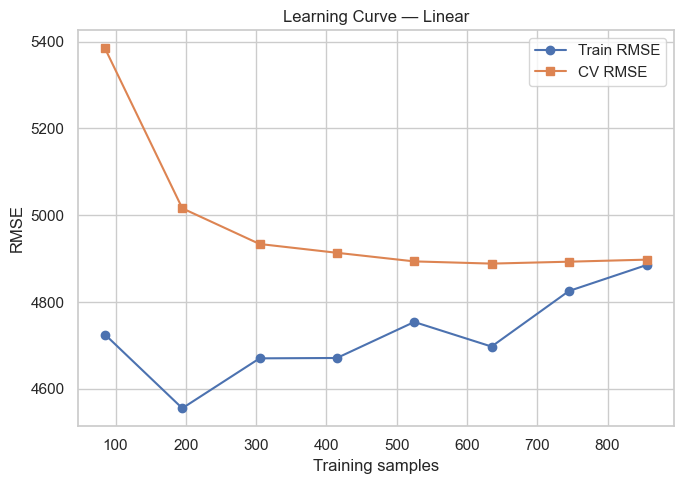

In [74]:
# 10) Learning Curve for the final model
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train, y_train,
    cv=outer_cv, scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1, shuffle=True, random_state=RANDOM_STATE
)

train_rmse = -train_scores.mean(axis=1)
val_rmse   = -val_scores.mean(axis=1)


from pathlib import Path
import os
import matplotlib.pyplot as plt


out_dir = Path(r"C:\Users\hasti_aksoy\OneDrive\Desktop\regression-classification-project1\reports\figures")
out_dir.mkdir(parents=True, exist_ok=True)


fig = plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_rmse, marker="o", label="Train RMSE")
plt.plot(train_sizes, val_rmse,   marker="s", label="CV RMSE")
plt.xlabel("Training samples")
plt.ylabel("RMSE")
plt.title(f"Learning Curve — {best_model_name}")
plt.legend()
plt.tight_layout()


out_file = out_dir / f"learning_curve_{best_model_name}.png"
fig.savefig(out_file, dpi=200, bbox_inches="tight")
print("Saved to:", out_file.resolve())


plt.show()



In [70]:
# 11) Export artifacts (Pipeline + Results)
Path("../models").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)

model_path = f"../models/final_{best_model_name.lower()}_pipeline.joblib"
joblib.dump(final_model, model_path)
print(f"Saved pipeline -> {model_path}")

# Save a compact results CSV
final_summary = pd.DataFrame({
    "best_model": [best_model_name],
    "rmse_test": [rmse],
    "mae_test": [mae],
    "r2_test": [r2],
    "mape_test": [mp],
    "rmsle_test": [rl],
    "params": [final_params]
})
final_csv = "../reports/final_results.csv"
final_summary.to_csv(final_csv, index=False)
print(f"Saved summary -> {final_csv}")



Saved pipeline -> ../models/final_linear_pipeline.joblib
Saved summary -> ../reports/final_results.csv


In [71]:
# 11) Export artifacts (Pipeline + Results)
Path("../models").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)

model_path = f"../models/final_{best_model_name.lower()}_pipeline.joblib"
joblib.dump(final_model, model_path)
print(f"Saved pipeline -> {model_path}")

# Save a compact results CSV
final_summary = pd.DataFrame({
    "best_model": [best_model_name],
    "rmse_test": [rmse],
    "mae_test": [mae],
    "r2_test": [r2],
    "mape_test": [mp],
    "rmsle_test": [rl],
    "params": [final_params]
})
final_csv = "../reports/final_results.csv"
final_summary.to_csv(final_csv, index=False)
print(f"Saved summary -> {final_csv}")



Saved pipeline -> ../models/final_linear_pipeline.joblib
Saved summary -> ../reports/final_results.csv
